# Global map of drag coefficient (JSL)

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41309/status,
Dashboard: /proxy/41309/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39273,Workers: 4
Dashboard: /proxy/41309/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:39353,Total threads: 1
Dashboard: /proxy/36609/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37627,


In [3]:
nx = 360
ny = 180
lat = np.full((ny),np.nan)
lon = np.full((nx),np.nan)
sigma = np.full((ny,nx),np.nan)
depth_z = np.full((ny,nx),np.nan)

## Loop through tiles and re-construct drag coefficient arrays

In [4]:
for i in range(400):
    # print(i+1)
    filename = '/g/data/nm03/lxy581/global_drag_coeff/sigma_JSL_2d_%03d.nc' % (i+1)
    # print(filename)
    itile = xr.open_dataset(filename)

    # infer the lon & lat from itile
    ilon = i//20+1
    ilat = i+1 - (ilon-1)*20
    # print(ilon,ilat)
    
    lon[(ilon-1)*18:ilon*18] = itile.lon
    lat[(ilat-1)*9:ilat*9] = itile.lat
    sigma[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile.sigma_JSL

0.3.0


## Ocean depth

In [5]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')

def get_depth(lon,lat):
    return topog.z.interp(lat=lat,lon=lon).values

In [6]:
for j in range(ny):
    for i in range(nx):
        depth_z[j,i] = get_depth(lon[i],lat[j])

In [7]:
depth_z[depth_z>0]=np.nan
depth_xr = xr.DataArray(depth_z, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])

## Interpolate to remove the missing band near 180°

In [8]:
mask_array = ~np.isnan(np.array(sigma))
sigma_xr   = xr.DataArray(sigma, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])

In [9]:
ds = xr.Dataset(data_vars={
                'sigma': (('lat','lon'), sigma),
                'mask': (('lat','lon'), mask_array)
                }, 
                coords={'lon': sigma_xr.lon,'lat': sigma_xr.lat})
ds_out = xr.Dataset({"lat": (["lat"], lat[16:-16]),
                     "lon": (["lon"], lon),
                     "mask": (["lat","lon"], ~np.isnan(depth_z[16:-16,:]))})
regridder = xe.Regridder(ds, ds_out, "bilinear", extrap_method="inverse_dist")
ds_out = regridder(ds)

## Interpolate to 1/4° grid

In [10]:
ds_low = xr.Dataset(data_vars={
                               'sigma_25': (('lat','lon'), np.array(ds_out['sigma'])),
                               'mask': (('lat','lon'), ~np.isnan(depth_z[16:-16,:]))
                               }, 
                    coords={'lon': ds_out['lon'],'lat': ds_out['lat']})
ds_high = xr.Dataset({"lat": (["lat"], np.arange(-75,75+0.25,0.25)),
                      "lon": (["lon"], np.arange(-180,180+0.25,0.25)),
                     })
regridder2 = xe.Regridder(ds_low, ds_high, "bilinear", extrap_method="inverse_dist")
ds_high = regridder2(ds_low)

## Plot drag coefficient

In [14]:
def plot_global(lon,lat,sigma,vmin,vmax):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title('Internal tide drag coefficient (JSL)')
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

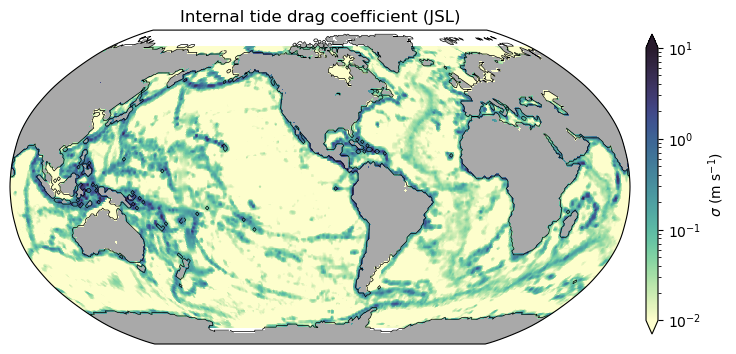

In [16]:
plot_global(ds_high['lon'],ds_high['lat'],ds_high['sigma_25'],1e-2,1e+1)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_JSL_025.png', dpi=300, bbox_inches='tight')